In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/computer_vision/tumor_3D_reconstruction_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/computer_vision/tumor_3D_reconstruction_project


In [ ]:
import os
print("cwd:", os.getcwd())
print("folders:", [x for x in os.listdir(".") if os.path.isdir(x)])


cwd: /content/drive/MyDrive/computer_vision/tumor_3D_reconstruction_project
folders: ['__pycache__', 'checkpoints', 'data', 'UNet', '.git']


In [ ]:
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from LiTSPatchDataset import *
from dice_score import dice_loss_fg, dice_eval
from tqdm import tqdm
from torch import sigmoid
from torch.amp import autocast, GradScaler
from UNet.unet_model import UNet

In [ ]:
import os, re

def build_pairs(*batch_dirs):
    pairs = []
    for d in batch_dirs:
        files = os.listdir(d)

        seg_files = [f for f in files if "segmentation" in f]
        for seg in sorted(seg_files):
            m = re.search(r"segmentation-(\d+)", seg)
            if not m:
                continue
            idx = m.group(1)


            vol_candidates = [
                f"volume-{idx}.nii",
            ]
            vol = next((v for v in vol_candidates if v in files), None)
            if vol is None:
                raise FileNotFoundError(f"Volume manquant pour {seg} dans {d}")

            pairs.append((os.path.join(d, vol), os.path.join(d, seg)))
    return pairs

pairs = build_pairs("./data/media/nas/01_Datasets/CT/LITS/Training_Batch1", "./data/media/nas/01_Datasets/CT/LITS/Training_Batch2")
print("Nb paires:", len(pairs))
print(pairs[0])


X_paths = [p[0] for p in pairs]
y_paths = [p[1] for p in pairs]

Nb paires: 131
('./data/media/nas/01_Datasets/CT/LITS/Training_Batch1/volume-0.nii', './data/media/nas/01_Datasets/CT/LITS/Training_Batch1/segmentation-0.nii')


In [ ]:
def show_grid(dataset, n=10, rows=2, cols=5, alpha=0.45):
    fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
    axes = np.ravel(axes)

    for i in range(n):
        x, y = dataset[i]


        x2d = x[0].detach().cpu().numpy()

        # y can be [H,W] or [1,H,W]
        y_np = y.detach().cpu().numpy()
        if y_np.ndim == 3:
            y2d = y_np[0]
        else:
            y2d = y_np

        ax = axes[i]
        ax.imshow(x2d, cmap="gray", interpolation="nearest")

        # overlay only on the tumor pixels
        tumor = (y2d > 0.5)
        ax.imshow(np.ma.masked_where(~tumor, tumor), cmap="Reds", alpha=alpha, interpolation="nearest")

        # contour
        ax.contour(tumor.astype(np.uint8), levels=[0.5], linewidths=1)

        ax.set_title(f"i={i} | tumor px={tumor.sum()}")
        ax.axis("off")

    # if the grid is bigger than n
    for j in range(n, rows*cols):
        axes[j].axis("off")

    plt.suptitle("maching tumor segmentation with the corresponding volume")
    plt.tight_layout()
    plt.show()


def show_preds(model, dataset, device, indices, threshold=0.5, alpha=0.45):
    model.eval()
    n = len(indices)
    fig, axes = plt.subplots(n, 3, figsize=(12, 4*n))
    if n == 1:
        axes = np.expand_dims(axes, 0)

    with torch.no_grad():
        for r, idx in enumerate(indices):
            x, y = dataset[idx]

            # x: [C,H,W] -> [1,C,H,W]
            xb = x.unsqueeze(0).to(device)

            logits = model(xb)
            prob = torch.sigmoid(logits)[0, 0].detach().cpu().numpy()
            pred = (prob > threshold)

            x2d = x[0].detach().cpu().numpy()

            y_np = y.detach().cpu().numpy()
            y2d = y_np[0] if y_np.ndim == 3 else y_np
            gt = (y2d > 0.5)

            # 1) image
            axes[r, 0].imshow(x2d, cmap="gray")
            axes[r, 0].set_title(f"Image (idx={idx})")
            axes[r, 0].axis("off")

            # 2) GT overlay
            axes[r, 1].imshow(x2d, cmap="gray")
            axes[r, 1].imshow(np.ma.masked_where(~gt, gt), cmap="Reds", alpha=alpha)
            axes[r, 1].set_title(f"GT (tumor px={gt.sum()})")
            axes[r, 1].axis("off")

            # 3) Pred overlay
            axes[r, 2].imshow(x2d, cmap="gray")
            axes[r, 2].imshow(np.ma.masked_where(~pred, pred), cmap="Reds", alpha=alpha)
            axes[r, 2].set_title(f"Pred (tumor px={pred.sum()})")
            axes[r, 2].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
def split_patients(patient_ids, train=0.8, val=0.15, test=0.05, seed=42):
    assert abs(train + val + test - 1.0) < 1e-9
    ids = list(patient_ids)
    random.Random(seed).shuffle(ids)

    n = len(ids)
    n_train = int(train * n)
    n_val = int(val * n)

    train_ids = ids[:n_train]
    val_ids   = ids[n_train:n_train+n_val]
    test_ids  = ids[n_train+n_val:]
    return train_ids, val_ids, test_ids

def make_paths(batch_dirs, patient_ids):
    X, Y = [], []
    for pid in patient_ids:
        for d in batch_dirs:
            vol = os.path.join(d, f"volume-{pid}.nii")
            seg = os.path.join(d, f"segmentation-{pid}.nii")
            if os.path.exists(vol) and os.path.exists(seg):
                X.append(vol); Y.append(seg)
                break
    return X, Y

max = 0
for d in ["./data/media/nas/01_Datasets/CT/LITS/Training_Batch1", "./data/media/nas/01_Datasets/CT/LITS/Training_Batch2"]:
        files = os.listdir(d)

        seg_files = [f for f in files if "volume" in f]
        for seg in sorted(seg_files):
            m = re.search(r"volume-(\d+)", seg)
            if not m:
                continue
            if int(m[1]) > max:
                 max = int(m[1])
            else:
                 continue

patient_ids = np.arange(max+1)

train_ids, val_ids, test_ids = split_patients(patient_ids)



X_train_paths, y_train_paths  = make_paths(["./data/media/nas/01_Datasets/CT/LITS/Training_Batch1", "./data/media/nas/01_Datasets/CT/LITS/Training_Batch2"], train_ids)
X_val_paths, y_val_paths= make_paths(["./data/media/nas/01_Datasets/CT/LITS/Training_Batch1", "./data/media/nas/01_Datasets/CT/LITS/Training_Batch2"], val_ids)
X_test_paths, y_test_paths= make_paths(["./data/media/nas/01_Datasets/CT/LITS/Training_Batch1", "./data/media/nas/01_Datasets/CT/LITS/Training_Batch2"], test_ids)
train_dataset = LiTSPatchDataset(X_train_paths,y_train_paths)
val_dataset = LiTSPatchDataset(X_val_paths,y_val_paths)
test_dataset = LiTSPatchDataset(X_test_paths,y_test_paths)



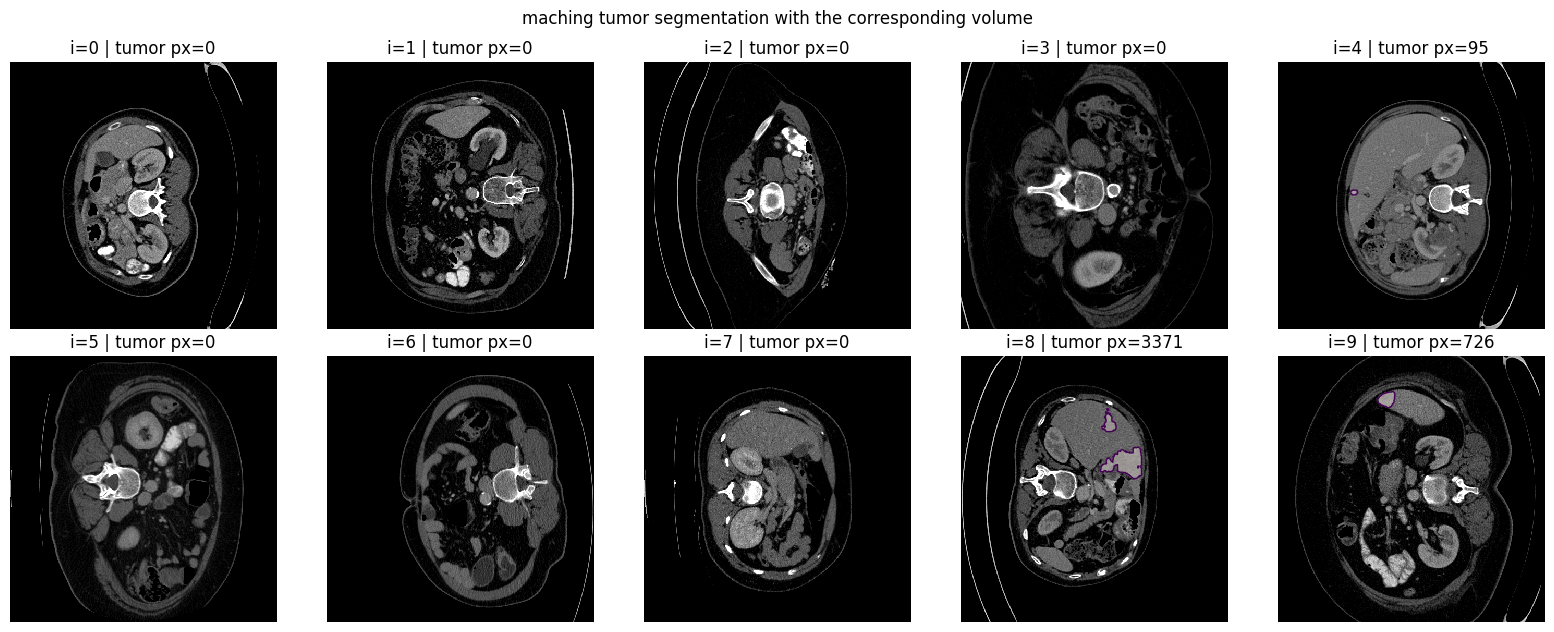

In [ ]:
show_grid(val_dataset, n=10, rows=2, cols=5, alpha=0.45)

In [ ]:
def unet_train(
    model,
    train_dataset,
    val_dataset,
    device,
    epochs: int = 10,
    batch_size: int = 1,
    l_rate: float = 1e-4,
    save_checkpoints: bool = True,
    weight_decay: float = 1e-5,
    patience: int = 7,
    min_delta: float = 0.005,
    run_name: str = "run"
):

    use_amp = (device.type == "cuda")
    scaler = GradScaler("cuda", enabled=use_amp)

    loader_args = dict(batch_size=batch_size, num_workers=0, pin_memory=True)




    train_loader = DataLoader(
        train_dataset,
        batch_size=loader_args["batch_size"],
        num_workers=loader_args["num_workers"],
        pin_memory=loader_args["pin_memory"],
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=loader_args["batch_size"],
        num_workers=loader_args["num_workers"],
        pin_memory=loader_args["pin_memory"],
        shuffle=False,
        drop_last=False
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=l_rate,
        betas=(0.9, 0.999),
        weight_decay=weight_decay
    )

    pos_weight = torch.tensor([25.0], device=device)
    bce_loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


    max_scan = min(len(val_dataset), 2000)
    tumor_idx, empty_idx = None, None

    for i in range(max_scan):
        _, y_tmp = val_dataset[i]
        if isinstance(y_tmp, np.ndarray):
            y_tmp = torch.from_numpy(y_tmp)
        s = y_tmp.sum().item()
        if s > 0 and tumor_idx is None:
            tumor_idx = i
        if s == 0 and empty_idx is None:
            empty_idx = i
        if tumor_idx is not None and empty_idx is not None:
            break

    if tumor_idx is None: tumor_idx = 0
    if empty_idx is None: empty_idx = 1 if len(val_dataset) > 1 else 0

    viz_subset = Subset(val_dataset, [tumor_idx, empty_idx])

    losses_train, losses_val, dices_val = [], [], []

    best_dice = -1.0
    epochs_no_improve = 0


    for epoch in range(epochs):
        model.train()
        cum_loss = 0.0
        nb_batches = 0

        for x_batch, y_batch in tqdm(train_loader, desc=f"Train epoch {epoch}", leave=False):
            x = x_batch.to(device)
            y = y_batch.to(device)

            if y.dim() == 3:
                y = y.unsqueeze(1)
            y = y.float()

            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=use_amp, device_type="cuda" if torch.cuda.is_available() else "cpu"):
                logits = model(x)
                loss = dice_loss_fg(logits, y) + bce_loss(logits, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            cum_loss += float(loss.item())
            nb_batches += 1

        loss_epoch = cum_loss / nb_batches if nb_batches > 0 else float("nan")

        model.eval()
        cum_loss_val = 0.0
        nb_val_batches = 0
        dice_sum = 0.0
        n_sum = 0

        with torch.no_grad():
            for x_batch, y_batch in tqdm(val_loader, desc=f"Val epoch {epoch}", leave=False):
                x = x_batch.to(device)
                y = y_batch.to(device)

                if y.dim() == 3:
                    y = y.unsqueeze(1)
                y = y.float()

                with autocast(enabled=use_amp, device_type="cuda" if torch.cuda.is_available() else "cpu"):
                    logits = model(x)
                    batch_loss_val = dice_loss_fg(logits, y) + bce_loss(logits, y)

                dice_batch, n_valid = dice_eval(logits, y)
                dice_sum += float(dice_batch) * int(n_valid)
                n_sum += int(n_valid)

                cum_loss_val += float(batch_loss_val.item())
                nb_val_batches += 1

        dice_epoch = (dice_sum / n_sum) if n_sum > 0 else float("nan")
        loss_val_epoch = (cum_loss_val / nb_val_batches) if nb_val_batches > 0 else float("nan")

        losses_train.append(loss_epoch)
        losses_val.append(loss_val_epoch)
        dices_val.append(dice_epoch)

        print("=="*10, f"epoch {epoch} metrics results", "=="*10)
        print(f"train loss: {loss_epoch:.6f}")
        print(f"val   loss: {loss_val_epoch:.6f}")
        print(f"val   dice: {dice_epoch}")

        if epoch % 2 == 0:
          show_preds(model, val_dataset, device, indices=[tumor_idx, empty_idx])


        if save_checkpoints:
            ckpt = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_dice": best_dice,
                "loss_train": losses_train,
                "loss_val": losses_val,
                "dice_val": dices_val,
            }
            torch.save(ckpt, f"{run_name}_last.pth")



        if not np.isnan(dice_epoch) and dice_epoch > best_dice + min_delta:
          best_dice = dice_epoch
          epochs_no_improve = 0

          if save_checkpoints:
            ckpt["best_dice"] = best_dice
            torch.save(ckpt, f"{run_name}_best.pth")
        else:
          epochs_no_improve += 1

        print(
            f"Best Dice: {best_dice:.4f} | "
            f"No improve: {epochs_no_improve}/{patience}"
          )

        if epochs_no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch}!")
          break



    plt.plot(losses_train, label="train")
    plt.plot(losses_val, label="val")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(dices_val, label="val dice")
    plt.title("Dice")
    plt.xlabel("Epochs")
    plt.ylabel("Dice")
    plt.legend()
    plt.show()

    return losses_train, losses_val, dices_val


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Device: cuda
GPU: NVIDIA L4


In [ ]:
unet = UNet(1, 1, bilinear = True).to(device)
losses_train, losses_val, dices_val = unet_train(unet, train_dataset=train_dataset, val_dataset=val_dataset, device = device, epochs=30, batch_size=8)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
max_epochs = 50
patience = 7
min_delta = 0.005

In [ ]:
unet = UNet(1, 1, bilinear=True).to(device)



checkpoint = torch.load("./checkpoints/checkpoint_best.pth", map_location=device)

unet.load_state_dict(checkpoint["model_state_dict"])


losses_train, losses_val, dices_val = unet_train(
    model=unet,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device=device,
    epochs=50,
    batch_size=4,
    l_rate=3e-4,
    patience=7,
    weight_decay=1e-4,
    min_delta=0.005,
    run_name="run_continued"
)



Output hidden; open in https://colab.research.google.com to view.